### Import Function and Libraries

#### Retrieving the high,low, close and open data from Yahoofinance. We will be performing cointegration with existing library.

In [174]:
import pandas as pd 
import numpy as np 
import yfinance as yf
from yahoofinancials import YahooFinancials
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from Data_Retrieval import DataRetrieval
from CC_test import CCstudy
import itertools
from pandas_datareader import data as pdr
from yahooquery import Ticker

In [175]:
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
from Spread import Spread

In [180]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
import warnings
warnings.filterwarnings('ignore')

### Use of yahooquery to retrieve the industry and sector according to ticker

### Industry and Sector dictionary

In [19]:
def classification(tickers):
    tickers = Ticker(tickers, asynchronous=True)
    
    datasi = tickers.get_modules("summaryProfile quoteType")
    dfsi = pd.DataFrame.from_dict(datasi).T
    dataframes = [pd.json_normalize([x for x in dfsi[module] if isinstance(x, dict)]) for
    module in ['summaryProfile', 'quoteType']]
    
    dfsi = pd.concat(dataframes, axis=1)
    
    dfsi = pd.DataFrame(dfsi.set_index('symbol'))
    dfsi=dfsi[['industry', 'sector']].reset_index()
    dfsi['symbol'].str.upper()
    return dfsi


### Import TW exchange counters

Our main focus in on Taiwan exchange counters hence we will import taiwan exchange ticker code and retrieve the adjusted closing price from yahoo finance API. Next, we will categorize it

In [23]:
counter_code = pd.read_csv('taiwan_stocks.csv')

In [24]:
tickers = list(counter_code.iloc[:,2])

In [25]:
tickers = list(counter_code.iloc[:,2].apply(lambda x: str(x)+".TW"))

In [26]:
tickers.append('0050.TW')

In [27]:
classlist = classification(tickers)

In [28]:
classlist

,symbol,industry,sector
0,1303.TW,Specialty Chemicals,Basic Materials
1,2002.TW,Steel,Basic Materials
2,2881.TW,Insurance - Life,Financial Services
3,2330.TW,Semiconductors,Technology
4,2409.TW,Electronic Components,Technology
...,...,...,...
189,1503.TW,Electrical Equipment & Parts,Industrials
190,5876.TW,Banks - Regional,Financial Services
191,6526.TW,Semiconductors,Technology
192,6139.TW,Engineering & Construction,Industrials


In [30]:
#tickers = ['2330.tw','0052.TW']
start_date = "2017-01-01"
end_date = "2025-01-12"

if tickers is not None:
    merged_df = DataRetrieval.retrieve_and_merge_data(tickers, start_date, end_date)
else:
    print("Error: tickers is None")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [32]:
merged_df = merged_df.dropna(axis=1, how='any')

In [34]:
merged_df

,1303.TW,2002.TW,2303.TW,2330.TW,2881.TW,1301.TW,2324.TW,2409.TW,2880.TW,2882.TW,...,1795.TW,1905.TW,1513.TW,3005.TW,8112.TW,1503.TW,6139.TW,5876.TW,6505.TW,0050.TW
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,47.744900,18.155310,7.756601,146.720352,28.886631,62.056217,11.817387,9.065211,9.712663,33.428661,...,56.543301,7.900723,14.171647,24.109896,12.488033,32.763050,25.612843,18.710472,83.657333,54.862881
2017-01-04,48.080189,18.340948,7.722582,146.720352,28.718027,62.193966,11.817387,9.027440,9.682776,33.359016,...,57.592167,7.866372,14.171647,24.263855,12.657775,32.763050,26.067717,18.842138,83.657333,54.824730
2017-01-05,49.220169,18.452328,7.756601,147.121216,28.886631,62.262844,11.912432,9.254069,9.772432,33.707233,...,58.164272,8.433164,14.756045,24.633356,12.827517,32.803543,25.717813,18.814419,84.803329,55.320709
2017-01-06,49.220169,18.340948,7.892684,147.522156,28.999025,62.331711,11.880751,9.480700,9.802317,33.950985,...,57.306107,8.544805,15.011719,24.356226,12.851763,32.803543,25.647833,18.897575,83.275337,55.435162
2017-01-09,49.488400,18.229563,7.892684,147.522156,29.055231,62.125084,11.817387,9.707330,9.832202,34.125092,...,55.780491,8.355873,14.938671,25.341564,12.997254,32.398567,25.053001,18.918365,83.275337,55.282539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06,31.250000,19.299999,43.400002,1125.000000,91.900002,36.250000,36.950001,14.500000,26.950001,68.800003,...,269.000000,16.600000,158.000000,107.000000,59.299999,194.500000,235.000000,40.700001,36.299999,199.394104
2025-01-07,29.950001,18.950001,42.349998,1130.000000,91.900002,34.549999,36.750000,14.700000,26.700001,69.099998,...,272.000000,16.299999,159.000000,108.000000,59.400002,191.500000,236.500000,40.500000,35.200001,201.613434
2025-01-08,29.299999,18.900000,42.700001,1105.000000,91.099998,33.250000,37.250000,14.600000,26.799999,68.800003,...,274.500000,16.350000,159.500000,108.500000,60.400002,190.000000,235.500000,40.700001,34.250000,198.605026


### Correlation and Cointegration Study 


Cointegration Test Results:


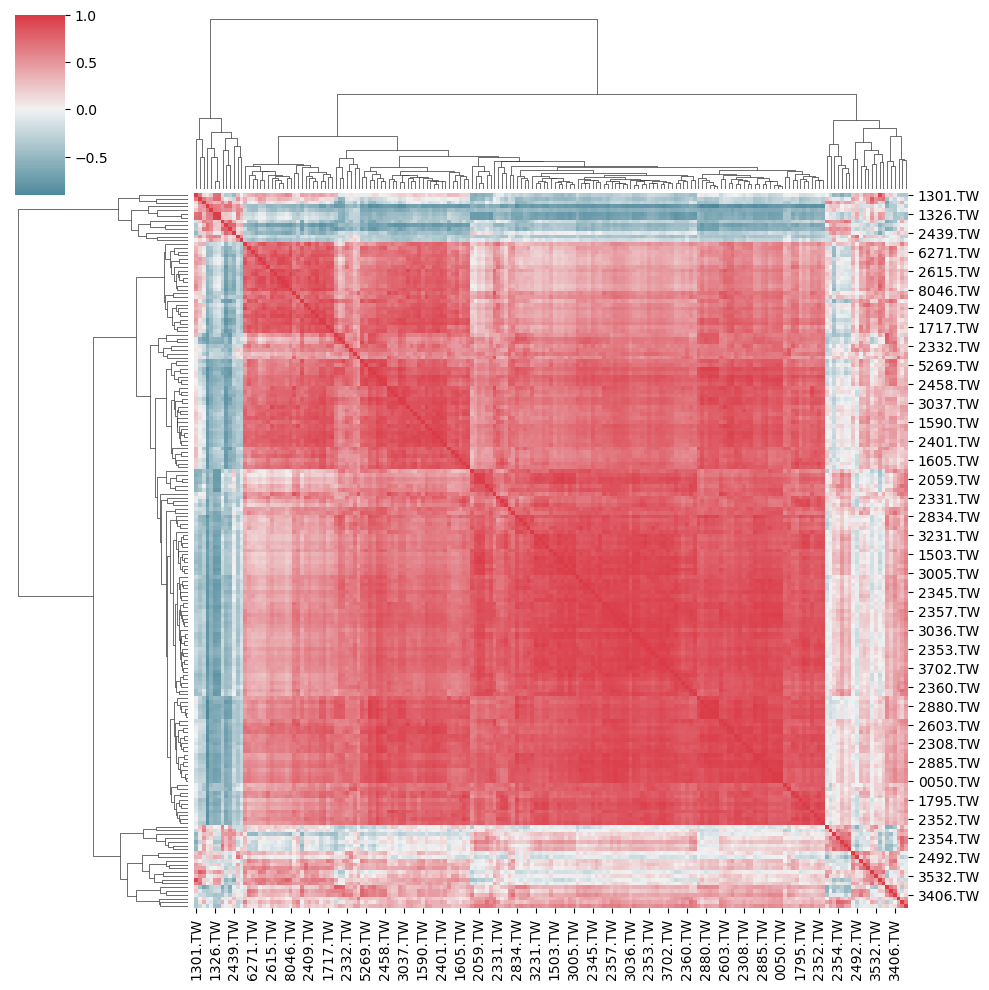

In [37]:
cc_study = CCstudy(merged_df)
table = cc_study.main()

In [38]:
table.sort_values(by=['Cointegration result','correlation'],ascending =[True,False])

,ticker1,ticker2,Cointegration result,correlation
8984,2059.TW,6139.TW,1.762316e-07,0.239532
15610,8163.TW,9958.TW,2.627717e-07,0.184729
14829,5534.TW,9958.TW,1.419316e-06,0.147395
11520,2449.TW,3706.TW,2.488047e-06,0.296413
17608,3017.TW,1503.TW,4.310568e-06,0.240291
...,...,...,...,...
5226,2357.TW,2014.TW,1.000000e+00,0.117103
14433,3533.TW,8454.TW,1.000000e+00,0.110064
17348,3706.TW,8454.TW,1.000000e+00,0.106432
17075,2345.TW,1904.TW,1.000000e+00,0.105152


In [39]:
table =table[(table['Cointegration result'] < 0.05) & (table['correlation'] > 0.5)].sort_values(by=['correlation','Cointegration result'],ascending =[False,True])

In [40]:
def categorize(classlist,column,counter):
    if column == 'industry':
        a=pd.DataFrame(dict(classlist.iloc[:,0:2]))
        return table[counter].map(a.set_index('symbol')[column])
    elif column == 'sector':
        b= pd.DataFrame(dict(classlist.iloc[:,[0,2]]))
        return table[counter].map(b.set_index('symbol')[column])
    else:
        return 'Error'

In [41]:
table['ticker1_industry'] = categorize(classlist,'sector','ticker1')
table['ticker2_industry'] = categorize(classlist,'sector','ticker2')


In [42]:
table

,ticker1,ticker2,Cointegration result,correlation,ticker1_industry,ticker2_industry
4884,1326.TW,6505.TW,0.000057,0.649700,Basic Materials,Energy
6590,2454.TW,0050.TW,0.000787,0.622163,Technology,NaN
3709,2603.TW,2606.TW,0.028106,0.572101,Industrials,Industrials
3876,2609.TW,2606.TW,0.000058,0.550646,Industrials,Industrials
6834,3231.TW,2356.TW,0.005166,0.527627,Technology,Technology
853,2881.TW,6005.TW,0.006649,0.521236,Financial Services,Financial Services
595,2330.TW,2454.TW,0.004709,0.515442,Technology,Technology
2289,2891.TW,6005.TW,0.024406,0.513634,Financial Services,Financial Services


### Selection of pair trading

In order to remove any industry specific systematic risk, the first criteria should be that the pair of stocks should belong to the same industry. Next, we shall run the time series spread graph.

In [45]:
Pair = []
for index, row in table.iterrows():
    Pair.append([row['ticker1'],row['ticker2']])

In [46]:
Pair

[['1326.TW', '6505.TW'],
 ['2454.TW', '0050.TW'],
 ['2603.TW', '2606.TW'],
 ['2609.TW', '2606.TW'],
 ['3231.TW', '2356.TW'],
 ['2881.TW', '6005.TW'],
 ['2330.TW', '2454.TW'],
 ['2891.TW', '6005.TW']]

Statistics for the spread between 1326.TW and 6505.TW: 
  Ticker 1 Ticker 2  Volatility     Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.01605         0.117861         -0.08576   

   Revert Time  
0    42.417722  


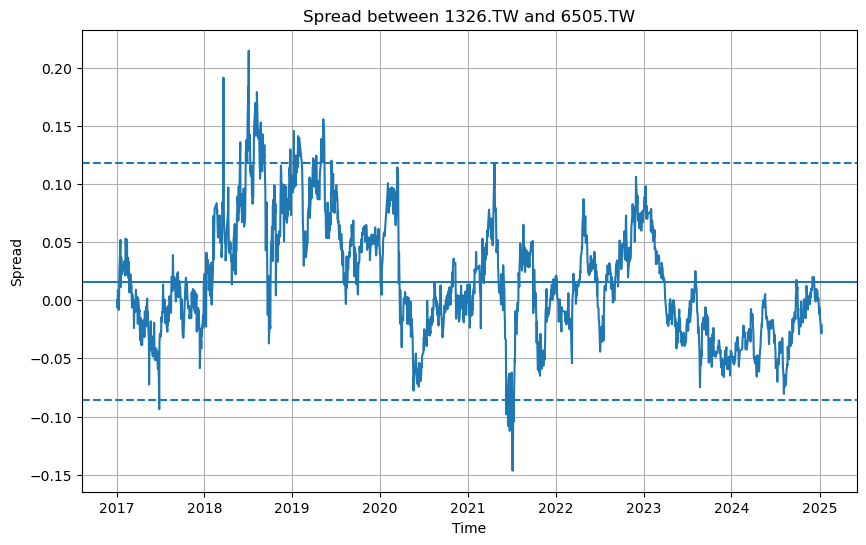

Statistics for the spread between 2454.TW and 0050.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.016050         0.117861        -0.085760   
1  2454.TW  0050.TW    1.675541  1.823831         5.174914        -1.527252   

   Revert Time  
0    42.417722  
1   106.823529  


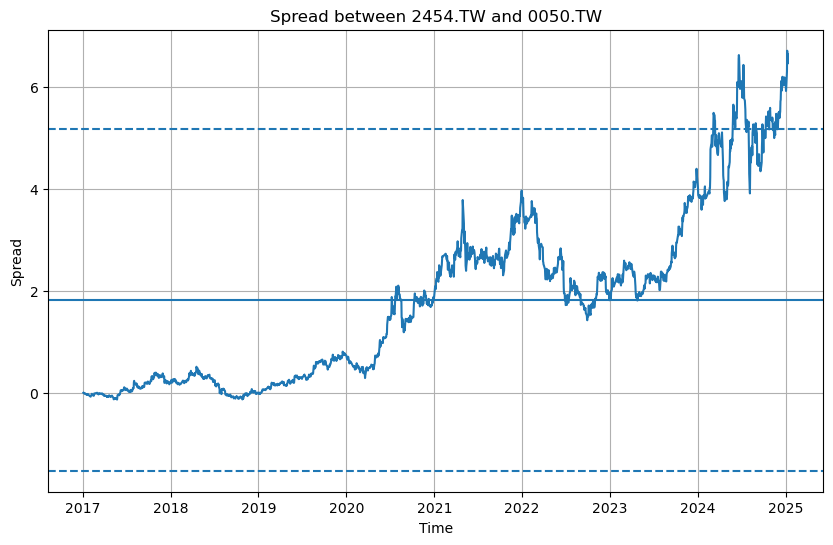

Statistics for the spread between 2603.TW and 2606.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.016050         0.117861        -0.085760   
1  2454.TW  0050.TW    1.675541  1.823831         5.174914        -1.527252   
2  2603.TW  2606.TW    5.272126  4.369814        14.914065        -6.174438   

   Revert Time  
0    42.417722  
1   106.823529  
2   100.117647  


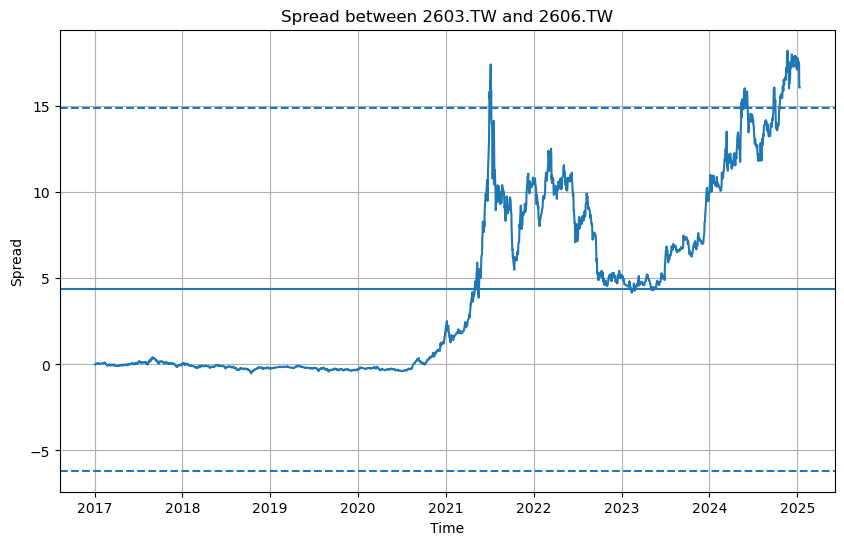

Statistics for the spread between 2609.TW and 2606.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.016050         0.117861        -0.085760   
1  2454.TW  0050.TW    1.675541  1.823831         5.174914        -1.527252   
2  2603.TW  2606.TW    5.272126  4.369814        14.914065        -6.174438   
3  2609.TW  2606.TW    4.023597  3.153527        11.200721        -4.893667   

   Revert Time  
0    42.417722  
1   106.823529  
2   100.117647  
3   302.833333  


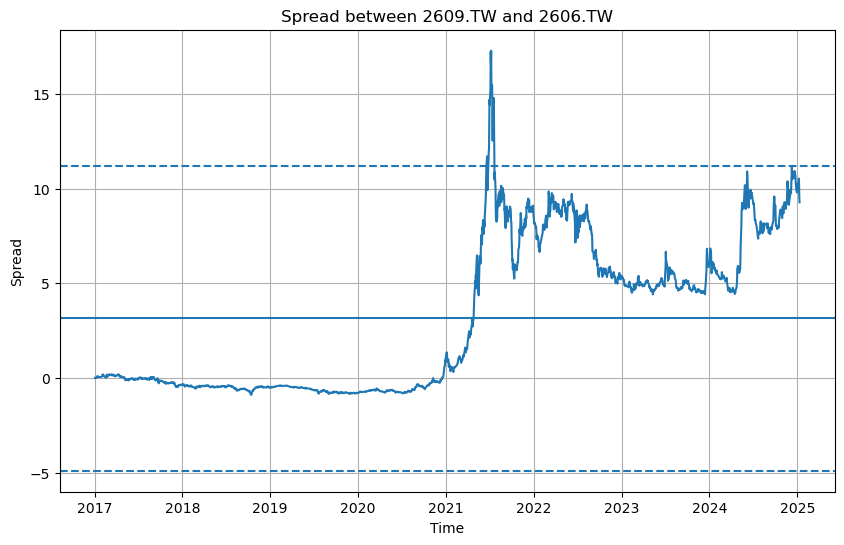

Statistics for the spread between 3231.TW and 2356.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.016050         0.117861        -0.085760   
1  2454.TW  0050.TW    1.675541  1.823831         5.174914        -1.527252   
2  2603.TW  2606.TW    5.272126  4.369814        14.914065        -6.174438   
3  2609.TW  2606.TW    4.023597  3.153527        11.200721        -4.893667   
4  3231.TW  2356.TW    1.367525  0.719841         3.454891        -2.015209   

   Revert Time  
0    42.417722  
1   106.823529  
2   100.117647  
3   302.833333  
4  1574.000000  


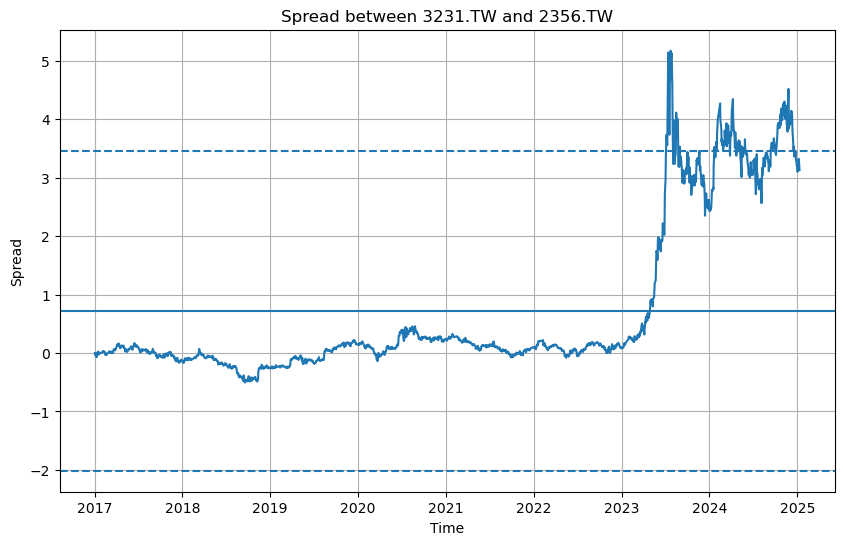

Statistics for the spread between 2881.TW and 6005.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.016050         0.117861        -0.085760   
1  2454.TW  0050.TW    1.675541  1.823831         5.174914        -1.527252   
2  2603.TW  2606.TW    5.272126  4.369814        14.914065        -6.174438   
3  2609.TW  2606.TW    4.023597  3.153527        11.200721        -4.893667   
4  3231.TW  2356.TW    1.367525  0.719841         3.454891        -2.015209   
5  2881.TW  6005.TW    0.376180 -0.410579         0.341782        -1.162939   

   Revert Time  
0    42.417722  
1   106.823529  
2   100.117647  
3   302.833333  
4  1574.000000  
5   108.363636  


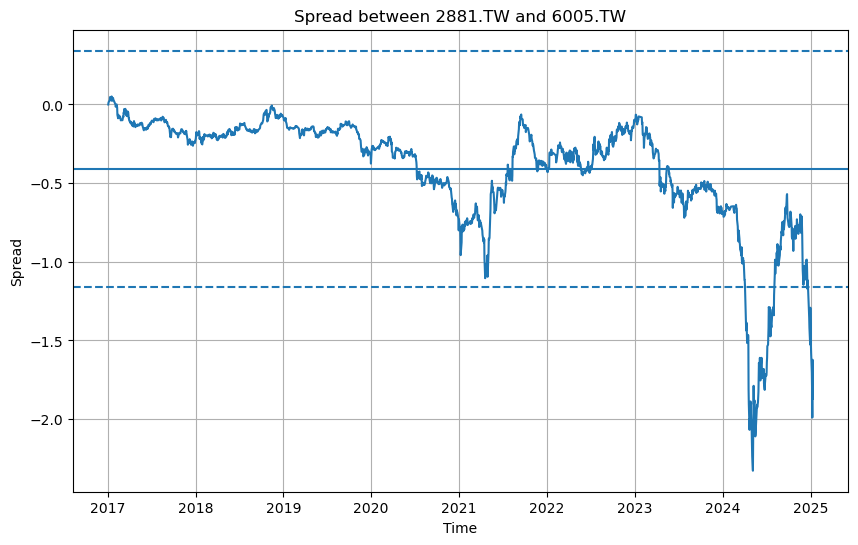

Statistics for the spread between 2330.TW and 2454.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.016050         0.117861        -0.085760   
1  2454.TW  0050.TW    1.675541  1.823831         5.174914        -1.527252   
2  2603.TW  2606.TW    5.272126  4.369814        14.914065        -6.174438   
3  2609.TW  2606.TW    4.023597  3.153527        11.200721        -4.893667   
4  3231.TW  2356.TW    1.367525  0.719841         3.454891        -2.015209   
5  2881.TW  6005.TW    0.376180 -0.410579         0.341782        -1.162939   
6  2330.TW  2454.TW    0.796262 -0.752483         0.840041        -2.345008   

   Revert Time  
0    42.417722  
1   106.823529  
2   100.117647  
3   302.833333  
4  1574.000000  
5   108.363636  
6    75.472222  


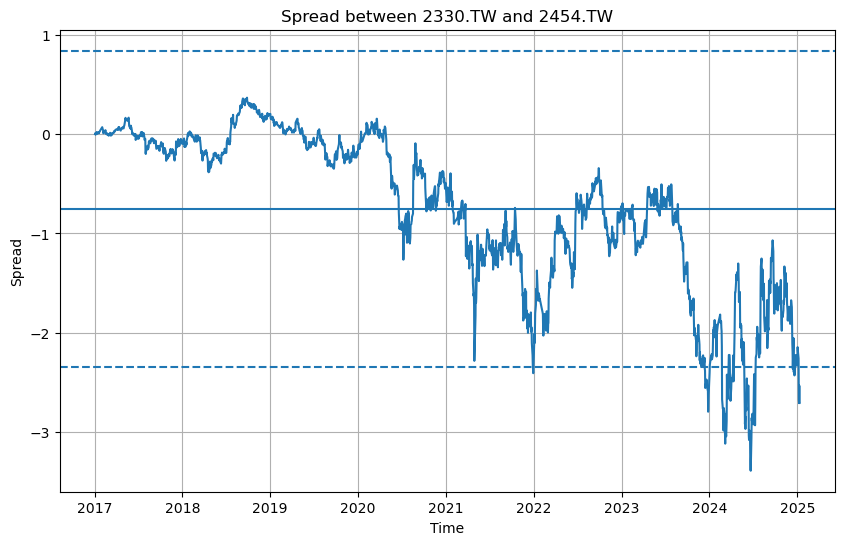

Statistics for the spread between 2891.TW and 6005.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  1326.TW  6505.TW    0.050905  0.016050         0.117861        -0.085760   
1  2454.TW  0050.TW    1.675541  1.823831         5.174914        -1.527252   
2  2603.TW  2606.TW    5.272126  4.369814        14.914065        -6.174438   
3  2609.TW  2606.TW    4.023597  3.153527        11.200721        -4.893667   
4  3231.TW  2356.TW    1.367525  0.719841         3.454891        -2.015209   
5  2881.TW  6005.TW    0.376180 -0.410579         0.341782        -1.162939   
6  2330.TW  2454.TW    0.796262 -0.752483         0.840041        -2.345008   
7  2891.TW  6005.TW    0.417125 -0.268487         0.565763        -1.102736   

   Revert Time  
0    42.417722  
1   106.823529  
2   100.117647  
3   302.833333  
4  1574.000000  
5   108.363636  
6    75.472222  
7   126.650000  


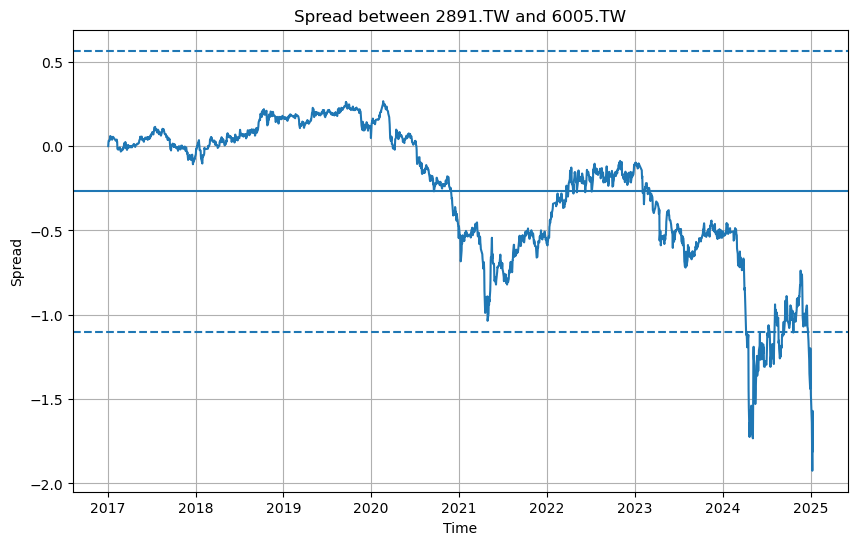

In [309]:
spread_calculator = Spread(merged_df)
Pairs = spread_calculator.calculate_spread_and_volatility(Pair)

In [193]:
Pairs

,Ticker 1,Ticker 2,Volatility,Mean,90th Percentile,10th Percentile,Revert Time
0,1326.TW,6505.TW,0.050905,0.016050,0.117861,-0.085760,42.417722
1,2454.TW,0050.TW,1.675541,1.823831,5.174914,-1.527252,106.823529
2,2603.TW,2606.TW,5.272126,4.369814,14.914065,-6.174438,100.117647
3,2609.TW,2606.TW,4.023597,3.153527,11.200721,-4.893667,302.833333
4,3231.TW,2356.TW,1.367525,0.719841,3.454891,-2.015209,1574.000000
5,2881.TW,6005.TW,0.376180,-0.410579,0.341782,-1.162939,108.363636
6,2330.TW,2454.TW,0.796262,-0.752483,0.840041,-2.345008,75.472222
7,2891.TW,6005.TW,0.417125,-0.268487,0.565763,-1.102736,126.650000


### Selection based on number of days holding trade

#### Another criteria I added in is that I want to hold this long-short pair and realize profit as quick as possible ideally. Hence, I would set a threshold of 60 days at most. 

In [313]:
Filtered_Pairs = Pairs[Pairs['Revert Time'] <50]

In [315]:
Filtered_Pairs

,Ticker 1,Ticker 2,Volatility,Mean,90th Percentile,10th Percentile,Revert Time
0,1326.TW,6505.TW,0.050905,0.01605,0.117861,-0.08576,42.417722


### Calculate hedging ratio 

In [319]:
FPairs= Filtered_Pairs[['Ticker 1', 'Ticker 2']].apply(pd.Series)

In [321]:
FPairs=FPairs[['Ticker 1', 'Ticker 2']]

In [323]:
FPairs

,Ticker 1,Ticker 2
0,1326.TW,6505.TW


In [325]:
import Hedge


# Now you can use the reloaded Hedge_ratio class
hedge_ratio_instance = Hedge.Hedge_ratio(FPairs, merged_df)
HR = hedge_ratio_instance.hedge(FPairs, merged_df)

In [327]:
HR

,ticker1,ticker2,rsq,hedge ratio
0,1326.TW,6505.TW,0.951147,1.0


### Backtest with signal 

#### Our signal will be when it hit the standard deviation then we will take position and unwind when it reaches the mean.

#### Assumption
1. Our price will be closing price
2. Not considering transaction cost
3. No borrowing cost consider might use SSF in TW to carry out this trade, assuming SSF same price and closing price 

In [538]:
from Backtest import Backtest

In [539]:
Backtest = Backtest(FPairs,merged_df,HR)
signal = Backtest.position()

              1326.TW Signal
Date                        
2017-01-03  68.052635    NaN
2017-01-04  67.982704    NaN
2017-01-05  68.542221    NaN
2017-01-06  68.332405    NaN
2017-01-09  67.982704    NaN
...               ...    ...
2025-01-06  28.049999    NaN
2025-01-07  26.799999    NaN
2025-01-08  26.100000    NaN
2025-01-09  25.350000    NaN
2025-01-10  25.299999    NaN

[1953 rows x 2 columns]


In [540]:
signal[signal['Signal'].notna()]

,1326.TW,Signal
Date,,
2017-06-27,66.653824,Buy
2018-03-21,82.438469,Sell
2018-05-29,87.265953,Sell
2018-05-30,86.523254,Sell
2018-06-22,87.265953,Sell
...,...,...
2021-07-05,75.859123,Buy
2021-07-06,76.122231,Buy
2021-07-07,75.245239,Buy


In [375]:
def signal(fpair,hedge_table,merged_df):
        for i, row in fpair.iterrows():
            ticker1 = row['Ticker 1']
            ticker2 = row['Ticker 2']
            spread_calculator = Spread(merged_df)
            spread= spread_calculator.calculate_spread(ticker1, ticker2)
            vol, mean, upper,lower = spread_calculator.compute_volatility(spread)
            # For every time the signal kick in we will spend 100k to long assuming current SGDTWD to be 25
            print(spread)

In [ ]:
for i,row in fpair.itterows:
    